In [1]:
from platform import python_version

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# factor analysis mixed data types
import prince
# seed
RANDOM_STATE = 1776

# set seaborn theme
sns.set_theme()

# print versions
print("Numpy Version: " + np.__version__)
print("Pandas Version: " + pd.__version__)
print("Seaborn Version: " + sns.__version__)
print("Matplotlib Version: " + plt.matplotlib.__version__)
print("Python Version: " + python_version())
print("Prince Version: " + prince.__version__)

# adjust pandas display options to max
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# adjust pandas display options to ensure full display of content
pd.set_option('display.max_colwidth', None)

Numpy Version: 1.26.4
Pandas Version: 2.2.3
Seaborn Version: 0.13.2
Matplotlib Version: 3.9.2
Python Version: 3.9.20
Prince Version: 0.13.0


### Import Data

In [2]:
# full dataframe
df = pd.read_pickle("../Data/CleanFullLabels.pkl")

# data dictionary
df_dict = pd.read_pickle("../Data/FinalcolumnDefinition.pkl")

# data label
df_label = pd.read_pickle("../Data/colLabel.pkl") 

# boolean
df_bool = pd.read_pickle("../Data/colBoolean.pkl")

# nominal
df_nominal = pd.read_pickle("../Data/colNominal.pkl")

# ordinal
df_ordinal = pd.read_pickle("../Data/colOrdinal.pkl")

# numeric
df_numeric = pd.read_pickle("../Data/colNumeric.pkl")

# checking for duplicated column name
df.columns[df.columns.duplicated()]

Index([], dtype='object')

#### Data Shape

In [3]:
# df DataFrame
print(f"Orginal Data file Shape: {df.shape}")
print(f"Label(s) Data rows: {len(df_label)}")
print(f"Boolean(s) Data rows: {len(df_bool)}")
print(f"Ordinal(s) Data rows: {len(df_ordinal)}")
print(f"Nominal(s) Data rows: {len(df_nominal)}")
print(f"Numeric(s) Data rows: {len(df_numeric)}")

Orginal Data file Shape: (14856, 180)
Label(s) Data rows: 13
Boolean(s) Data rows: 17
Ordinal(s) Data rows: 34
Nominal(s) Data rows: 99
Numeric(s) Data rows: 30


### User Function(s):

In [4]:
def corrCols(df, threshold=0.9, method='pearson', flag=False):
    """
    Determine highly corrlated features
    """
    # initilaize variable
    c1 = list()
    c2 = list()
    # calculate the correlation matrix
    correlation_matrix = df.select_dtypes(exclude='object').corr(method=method)
    
    # get the number of features
    num_features = correlation_matrix.shape[0]
    
    # iterate over the upper triangular part of the matrix
    for i in range(num_features):
        for j in range(i+1, num_features):
            feature1 = correlation_matrix.index[i]
            feature2 = correlation_matrix.columns[j]
            correlation = correlation_matrix.iloc[i, j]
            if abs(correlation) > threshold:
                c1.append(feature1)
                c2.append(feature2)
                print(f"Correlation between {feature1} and {feature2}: {correlation:.3f}")

    if flag:
        return c1,c2
    else:
        return
    

def percentageNull(df):
    """
    Calculate percentage of NaN & NaN count
    """
    # calculate the percentage of non-null values for each column
    per_calc = pd.DataFrame(100 - (df.count() / len(df) * 100))
    
    # rename columns name
    per_calc.rename(columns={0: 'percentage'}, inplace=True)

    # add counter
    per_calc['NaNCount'] = df.isna().sum()
    
    # sort
    per_calc.sort_values(by='percentage', inplace=True, ascending=False)

    # 
    NanReturn = per_calc[per_calc.NaNCount != 0]
    
    return NanReturn


def DefinitionSearch(datadic, col, flag=False):
    # initialize variable
    parm =  "r'(?i)" + col + "'" # regex search using ignore case sensitivity
    parm = eval(parm)
    # display
    df_str = datadic.loc[:,['featureName','desc', 'dataType', 'labelSAS', 'COMMENT', 'Information']][datadic.featureName.str.contains(parm)]

    if flag:
        feature = datadic.featureName[datadic.featureName.str.contains(parm)].tolist()
        return feature
    else:
        return df_str
    
    
def removeColumn(data, col):
    """
    Remove unwanted columns
    """
    # display removed feature(s)
    print(f"\nRemoved Features:{col}\n")
    # display shape of DataFrame
    print(f"Total rows before: {data.shape[0]:,} & columns: {data.shape[1]:,}")
    
    # remove column
    data.drop(columns=col, axis=1, inplace=True)

    # reset index in place
    data.reset_index(drop=True, inplace=True)

    # display shape of DataFrame
    print(f"Total rows after: {data.shape[0]:,} & columns: {data.shape[1]:,}")

    return data


def removeRowUsingMask(data, removeColLst, colstr):
    # boolean mask
    mask = ~data[colstr].isin(removeColLst)
    
    # apply the mask to keep only rows where 'removeColLst'
    data = data[mask]
    
    # reset the index if needed
    data = data.reset_index(drop=True)

    # disply row removed msg
    print(f"Remove row(s) from df_{colstr} DataFrame.")

    return data

    
def updateDataDict(data, remove, col="COMMENT"):
    """
    Maintain data dictionary
    """
    # update data dictionary
    idx = data[data.featureName.isin(remove)].index
    # append to exiting data
    data.loc[idx,col] = "**REMOVED 6** - " + data[col]

    # disply update msg
    print(f"Data Dictionary Updated.")

    return data


def removeHouseKeeping(data, removeColLst, dataBool, dataOrdinal, dataNominal, dataNumeric, dataLabel):
    """
    Run helper fuction for house keeping
    """
    # remove DataFrame data (house keeping)
    dataLabel = removeRowUsingMask(dataLabel, removeColLst, colstr='label')
    dataBool = removeRowUsingMask(dataBool, removeColLst, colstr='boolean')
    dataOrdinal = removeRowUsingMask(dataOrdinal, removeColLst, colstr='ordinal')
    dataNominal = removeRowUsingMask(dataNominal, removeColLst, colstr='nominal')
    dataNumeric = removeRowUsingMask(dataNumeric, removeColLst, colstr='numeric')
    
    # remove features
    data = removeColumn(data, removeColLst)

    return data, dataBool, dataOrdinal, dataNominal, dataNumeric, dataLabel


def datatypeDF(data, databool, datanominal, dataordinal, datanumeric):    
    # initialize variables for all the column name per each datatype
    boolCol = databool.boolean.to_list()
    nominalCol = datanominal.nominal.to_list()
    ordinalCol = dataordinal.ordinal.to_list()
    numericCol = datanumeric.numeric.to_list()

    print('Total Data feature count: ', data.shape[1])
    print(f"\nBoolean feature count: {len(boolCol)}")
    print(f"Nominal feature count: {len(nominalCol)}")
    print(f"Ordinal feature count: {len(ordinalCol)}")
    print(f"Numeric feature count: {len(numericCol)}")
    print('\nTotal feature count: ' ,len(boolCol) + len(nominalCol) + len(ordinalCol) + len(numericCol))

    # return list for each type
    return boolCol, nominalCol, ordinalCol, numericCol


def addtionalInfo(data, lst):
    # iterate
    for val in lst:
        # mode (first if multiple)
        modeValue = data[val].mode()[0]
        modePercentage = data[val].value_counts(normalize=True, dropna=False)[modeValue]
        modeCount = data[val].value_counts()[modeValue]
        unique = data[val].nunique(dropna=False)

        # display
        print(f"**{val}** Unique: {unique} & Mode: {modeValue} & Occurrence Count: {modeCount:,} & Percentage Occurrence: {(modePercentage * 100):.2f}%")


def removeCatZeroCount(data):
    """
    Remove category with no category values
    """
    # iterate each categorical column
    for column in data.select_dtypes(['category']).columns:
        # get counts of each category
        category_counts = data[column].value_counts()
        
        # remove categories with zero counts
        categories_to_keep = category_counts[category_counts > 0].index
        data[column] = data[column].cat.remove_categories([cat for cat in data[column].cat.categories if cat not in categories_to_keep])

    return data



# import library
from scipy.stats import chi2_contingency
from itertools import combinations


def pairColsMultiIndependenceCat(data, catCol):
    """
    Hypothesis testing using Chi-square statistic and calculating Cramer's V to 
    build consensus for all the categorical variables. 
    """
    # initialize variables
    results = []
    validCols = [col for col in catCol if col in data.columns]

    # use combinations to get unique pairs of columns
    for col1, col2 in combinations(validCols, 2):
        # create a contingency table
        contingencyTable = pd.crosstab(data[col1], data[col2])
        chi2, p_value, _, _ = chi2_contingency(contingencyTable)
        # total number of observations
        n = contingencyTable.values.sum()
        # get the number of categories in each variable (rows and columns)
        r, k = contingencyTable.shape
        min_dim = min(r-1, k-1)
        
        # handle division by zero
        if n * min_dim == 0:
            cramer_v = np.nan
        else:
            cramer_v = np.sqrt(chi2 / (n * min_dim))
        
        results.append({
            'column1': col1,
            'column2': col2,
            'chi2': chi2,
            'p_value': p_value,
            'cramer_v': cramer_v
        })
    
    return pd.DataFrame(results).sort_values(by='cramer_v', ascending=False)
    
    
def testIndependenceCat(data, cat1, cat2, flag=False):
    """
    Hypothesis testing using Ch-square statistic and calculating Cramer's V to 
    build consensus for two categorical variables.
    """
    # create a contingency table
    contingencyTable = pd.crosstab(data[cat1], data[cat2])
    # perform Chi-square test
    chi2, p_value, _, _ = chi2_contingency(contingencyTable)
    
    # total number of observations
    n = contingencyTable.sum().sum()
    # get the number of categories in each variable (rows and columns)
    r, k = contingencyTable.shape
    # calculate Cramer's V
    cramer_v = np.sqrt(chi2 / (n * min(k-1, r-1)))

    # display
    print(f"Test of Independence for Catergorical Variables: {cat1} & {cat2}")
    print(f"Chi-square statistic: {chi2:,.2f}")
    print(f"p-value: {p_value:,.4f}")
    print(f"Cramer's V: {cramer_v:,.4f}")

    if flag:
        return contingencyTable

In [5]:
# display NaNs
DFNaN = percentageNull(df)

# display
DFNaN.head(15)

,percentage,NaNCount


In [6]:
# initialize list
boolCol, nominalCol, ordinalCol, numericCol =  datatypeDF(df, df_bool, df_nominal, df_ordinal, df_numeric)   

Total Data feature count:  180

Boolean feature count: 17
Nominal feature count: 99
Ordinal feature count: 34
Numeric feature count: 30

Total feature count:  180


### Feature Engineering

#### Numeric

In [7]:
print(sorted(df_numeric.numeric.to_list()))

['AgeCalc_DON', 'Age_CAN', 'BMI_CAN', 'BMI_DON', 'BloodPH_DON', 'BloodUreaNitrogenLevel_DON', 'Creatinine_CAN', 'Creatinine_DON', 'DistanceFrom_HospitaltoTXCenter', 'HeightCm_CAN', 'HeightCm_DON', 'Hematocrit_DON', 'Hemodynamics_CO_CAN', 'Hemodynamics_PA_DIA_CAN', 'Hemodynamics_PA_MN_CAN', 'Hemodynamics_PCW_CAN', 'Hemodynamics_SYS_CAN', 'IschemicTimeHours_DON', 'LV_EjectionFractionPercent_DON', 'LengthOfStay_CAN', 'Level_SGOT_ALT_DON', 'Level_SGOT_AST_DON', 'PCO2_DON', 'PF_Ratio_DON', 'TotalBilirubin_CAN', 'TotalBilirubin_DON', 'TotalDayWaitList_CAN', 'TransplantSurvivalDay_CAN', 'WeightKg_CAN', 'WeightKg_DON']


In [8]:
# add to list
removeCol = ['AgeCalc_DON', 'Age_CAN', 'BMI_CAN','BMI_DON','Creatinine_CAN', 'Creatinine_DON', 'HeightCm_CAN', 'HeightCm_DON', 'Hemodynamics_CO_CAN', 'Hemodynamics_PA_DIA_CAN', \
             'Hemodynamics_PA_MN_CAN', 'Hemodynamics_PCW_CAN', 'Hemodynamics_SYS_CAN', 'Level_SGOT_ALT_DON', 'Level_SGOT_AST_DON', \
             'TotalBilirubin_CAN', 'TotalBilirubin_DON', 'WeightKg_CAN', 'WeightKg_DON']

In [9]:
# new features
df['Age_Difference'] = df.AgeCalc_DON - df.Age_CAN
df['BMI_Difference'] = df.BMI_DON - df.BMI_CAN
df['Creatinine_Difference'] = df.Creatinine_DON - df.Creatinine_CAN
df['HeightCm_Difference'] = df.HeightCm_DON - df.HeightCm_CAN
df['Hemodynamics_CAN_Addtion'] = df[['Hemodynamics_CO_CAN', 'Hemodynamics_PA_DIA_CAN', 'Hemodynamics_PA_MN_CAN', 'Hemodynamics_PCW_CAN', 'Hemodynamics_SYS_CAN']].sum(axis=1)
df['TotalBilirubin_Difference'] = df.TotalBilirubin_DON - df.TotalBilirubin_CAN
df['WeightKg_Difference'] = df.WeightKg_DON - df.WeightKg_CAN
df['Level_SGOT_DON_Difference'] = df.Level_SGOT_ALT_DON - df.Level_SGOT_AST_DON

# add to df_numeric
df_numeric.loc[len(df_numeric)] = 'Age_Difference'
df_numeric.loc[len(df_numeric)] = 'BMI_Difference'
df_numeric.loc[len(df_numeric)] = 'Creatinine_Difference'
df_numeric.loc[len(df_numeric)] = 'HeightCm_Difference'
df_numeric.loc[len(df_numeric)] = 'TotalBilirubin_Difference'
df_numeric.loc[len(df_numeric)] = 'Level_SGOT_DON_Difference'
df_numeric.loc[len(df_numeric)] = 'Hemodynamics_CAN_Addtion'
df_numeric.loc[len(df_numeric)] = 'WeightKg_Difference'

In [10]:
df_dict[df_dict.featureName.str.contains('Level_SGOT|Hemodynamics|TotalBilirubin', regex=True)]

,featureName,desc,form,formSection,dataType,labelSAS,COMMENT,Information
120,Hemodynamics_CO_CAN,MOST RECENT HEMODYNAMICS CO L/MIN @ REGISTRATION,TCR,CLINICAL INFORMATION,Continuous - NUM,TCR CO L/MIN,BOTH BEST AND BASELINE COLLECTED BETWEEN 04/01/1994 AND 10/25/1999. AFTER 10/25/1999 ONE VALUE COLLECTED.,"**REMOVE** New Continuous Hemodynamics_CO_difference & Hemodynamics_PA_DIA_difference & Hemodynamics_PA_MN_difference & Hemodynamics_PCW_difference & Hemodynamics_SYS_difference - {'HEMO_CO_TCR': 'Hemodynamics_CO_CAN', 'HEMO_CO_TRR': 'HemodynamicsAfter_CO_CAN', 'HEMO_PA_DIA_TCR': 'Hemodynamics_PA_DIA_CAN', 'HEMO_PA_DIA_TRR': 'HemodynamicsAfter_PA_DIA_CAN', 'HEMO_PA_MN_TCR': 'Hemodynamics_PA_MN_CAN', 'HEMO_PA_MN_TRR': 'HemodynamicsAfter_PA_MN_CAN', 'HEMO_PCW_TCR': 'Hemodynamics_PCW_CAN', 'HEMO_PCW_TRR': 'HemodynamicsAfter_PCW_CAN', 'HEMO_SYS_TCR': 'Hemodynamics_SYS_CAN', 'HEMO_SYS_TRR': 'HemodynamicsAfter_SYS_CAN'} - Hemodynamics is how your blood flows through your blood vessels. Many factors affect how well your blood can move throughout your body. Your heart and blood vessels can make adjustments to deliver enough oxygen for your body's needs."
121,HemodynamicsAfter_CO_CAN,MOST RECENT HEMODYNAMICS CO L/MIN @ TRANSPLANT,TRR,PRETRANSPLANT CLINICAL INFORMATION,Continuous - NUM,TRR CO L/MIN,BOTH BEST AND BASELINE COLLECTED BETWEEN 04/01/1994 AND 10/25/1999. AFTER 10/25/1999 ONE VALUE COLLECTED.,"**REMOVE** New Continuous Hemodynamics_CO_difference & Hemodynamics_PA_DIA_difference & Hemodynamics_PA_MN_difference & Hemodynamics_PCW_difference & Hemodynamics_SYS_difference - {'HEMO_CO_TCR': 'Hemodynamics_CO_CAN', 'HEMO_CO_TRR': 'HemodynamicsAfter_CO_CAN', 'HEMO_PA_DIA_TCR': 'Hemodynamics_PA_DIA_CAN', 'HEMO_PA_DIA_TRR': 'HemodynamicsAfter_PA_DIA_CAN', 'HEMO_PA_MN_TCR': 'Hemodynamics_PA_MN_CAN', 'HEMO_PA_MN_TRR': 'HemodynamicsAfter_PA_MN_CAN', 'HEMO_PCW_TCR': 'Hemodynamics_PCW_CAN', 'HEMO_PCW_TRR': 'HemodynamicsAfter_PCW_CAN', 'HEMO_SYS_TCR': 'Hemodynamics_SYS_CAN', 'HEMO_SYS_TRR': 'HemodynamicsAfter_SYS_CAN'} - Hemodynamics is how your blood flows through your blood vessels. Many factors affect how well your blood can move throughout your body. Your heart and blood vessels can make adjustments to deliver enough oxygen for your body's needs."
122,Hemodynamics_PA_DIA_CAN,MOST RECENT HEMODYNAMICS PA (DIA) MM/HG @ REGISTRATION,TCR,CLINICAL INFORMATION,Continuous - NUM,TCR PA(DIA) MM/HG,BOTH BEST AND BASELINE COLLECTED BETWEEN 04/01/1994 AND 10/25/1999. AFTER 10/25/1999 ONE VALUE COLLECTED.,"**REMOVE** New Continuous Hemodynamics_CO_difference & Hemodynamics_PA_DIA_difference & Hemodynamics_PA_MN_difference & Hemodynamics_PCW_difference & Hemodynamics_SYS_difference - {'HEMO_CO_TCR': 'Hemodynamics_CO_CAN', 'HEMO_CO_TRR': 'HemodynamicsAfter_CO_CAN', 'HEMO_PA_DIA_TCR': 'Hemodynamics_PA_DIA_CAN', 'HEMO_PA_DIA_TRR': 'HemodynamicsAfter_PA_DIA_CAN', 'HEMO_PA_MN_TCR': 'Hemodynamics_PA_MN_CAN', 'HEMO_PA_MN_TRR': 'HemodynamicsAfter_PA_MN_CAN', 'HEMO_PCW_TCR': 'Hemodynamics_PCW_CAN', 'HEMO_PCW_TRR': 'HemodynamicsAfter_PCW_CAN', 'HEMO_SYS_TCR': 'Hemodynamics_SYS_CAN', 'HEMO_SYS_TRR': 'HemodynamicsAfter_SYS_CAN'} - Hemodynamics is how your blood flows through your blood vessels. Many factors affect how well your blood can move throughout your body. Your heart and blood vessels can make adjustments to deliver enough oxygen for your body's needs."
123,HemodynamicsAfter_PA_DIA_CAN,MOST RECENT HEMODYNAMICS PA (DIA) MM/HG @ TRANSPLANT,TRR,PRETRANSPLANT CLINICAL INFORMATION,Continuous - NUM,TRR PA(DIA) MM/HG,BOTH BEST AND BASELINE COLLECTED BETWEEN 04/01/1994 AND 10/25/1999. AFTER 10/25/1999 ONE VALUE COLLECTED.,"**REMOVE** New Continuous Hemodynamics_CO_difference & Hemodynamics_PA_DIA_difference & Hemodynamics_PA_MN_difference & Hemodynamics_PCW_difference & Hemodynamics_SYS_difference - {'HEMO_CO_TCR': 'Hemodynamics_CO_CAN', 'HEMO_CO_TRR': 'HemodynamicsAfter_CO_CAN', 'HEMO_PA_DIA_TCR': 'Hemodynamics_PA_DIA_CAN', 'HEMO_PA_DIA_TRR': 'HemodynamicsAfter_

##### Test of Independence for Categorical Variables
- Null Hypothesis (H0): The two variables are not related.
- Alternative Hypothesis (H1): The two variables are related.
- A low p-value (typically < 0.05) indicates a significant relationship between the variables.
- This is the Chi-Square test statistic. It measures the discrepancy between the observed and expected frequencies under the assumption that the variables are independent.
    - A larger `chi2` value indicates a greater difference between observed and expected counts, suggesting that the variables are more likely to be associated.
    - A small p_value (typically < 0.05) suggests that you can reject the null hypothesis and conclude that there is a significant association between the two variables.

##### Cramer's V values can be interpreted as:
- Cramer's V is a measure of association between two nominal (categorical) variables, based on the Chi-Square statistic and varies from `0` (corresponding to no association between the variables) to `1` (complete association) and can reach 1 only when each variable is completely determined by the other.
    - 0.00 to 0.10: Negligible association
    - 0.10 to 0.30: Weak association
    - 0.30 to 0.50: Moderate association
    - 0.50 to 0.70: Strong association
    - 0.70 to 1.00: Very strong association

#### Nominal

In [11]:
print(sorted(df_nominal.nominal.to_list()))

['AcuteRejectionEpisode_CAN', 'AirwayDehiscencePostTransplant_CAN', 'AntibodyResultHBSAB_DON', 'Antibody_HEP_C_DON', 'Antihypertensive_DON', 'ArginnieManagement_DON', 'AtTransplantSurfaceHBVAntibodyTotal_CAN', 'Biopsy_DON', 'BloodGroup_CAN', 'BloodGroup_DON', 'BronchoscopyLeft_DON', 'BronchoscopyRight_DON', 'CMVStatusAtTransplant_CAN', 'Cancer_DON', 'CardiacArrest_DON', 'CauseOfDeath_DON', 'CerebrovascularDisease_CAN', 'ChestXray_DON', 'ChronicSteroidsUse_CAN', 'CigaretteHistory_DON', 'CigaretteUse_CAN', 'ClinicalInfection_DON', 'CocaineUse_DON', 'CoronaryAngiogram_DON', 'CrossMatch', 'DeathMechanism_DON', 'DeceasedRetyped_DON', 'DefibrillatorImplant_CAN', 'Diabetes_CAN', 'Diabetes_DON', 'DiagnosisType_CAN', 'DialysisAfterList_CAN', 'DialysisPrior_CAN', 'Diuretics_DON', 'EpsteinBarrStatusTransplant_CAN', 'EpsteinBarr_IGG_DON', 'EpsteinBarr_IGM_DON', 'ExtracanialCancer_DON', 'FollowUpFunctionalStatus_CAN', 'GraftFailed_CAN', 'GraftStatus_CAN', 'HeartProcedureType_CAN', 'HeavyAlcoholUse_

In [12]:
df.DiagnosisType_CAN.value_counts()

DiagnosisType_CAN
DILATED MYOPATHY                                             11844
RESTRICTIVE MYOPATHY                                           655
CONGENITAL HEART DEFECT                                        546
HYPERTROPHIC CARDIOMYOPATHY                                    473
HEART RE-TX/GF                                                 421
CORONARY ARTERY DISEASE                                        321
Unknown                                                        298
VALVULAR HEART DISEASE                                         154
ARRHYTHMOGENIC RIGHT VENTRICULAR DYSPLASIA/CARDIOMYOPATHY      127
MUSCULAR DYSTROPHY                                              15
CANCER                                                           2
Name: count, dtype: int64

In [13]:
df.PrimaryDiagnosisCode_CAN.value_counts()

PrimaryDiagnosisCode_CAN
DILATED MYOPATHY                                             11840
RESTRICTIVE MYOPATHY                                           638
CONGENITAL HEART DEFECT                                        550
HYPERTROPHIC CARDIOMYOPATHY                                    473
HEART RE-TX/GF                                                 421
CORONARY ARTERY DISEASE                                        333
Unknown                                                        306
VALVULAR HEART DISEASE                                         171
ARRHYTHMOGENIC RIGHT VENTRICULAR DYSPLASIA/CARDIOMYOPATHY      112
MUSCULAR DYSTROPHY                                              11
CANCER                                                           1
Name: count, dtype: int64

In [14]:
df.WaitListDiagnosisCode_CAN.value_counts()

WaitListDiagnosisCode_CAN
DILATED MYOPATHY                                             12004
RESTRICTIVE MYOPATHY                                           639
CONGENITAL HEART DEFECT                                        560
HYPERTROPHIC CARDIOMYOPATHY                                    477
HEART RE-TX/GF                                                 436
CORONARY ARTERY DISEASE                                        292
Unknown                                                        178
VALVULAR HEART DISEASE                                         143
ARRHYTHMOGENIC RIGHT VENTRICULAR DYSPLASIA/CARDIOMYOPATHY      114
MUSCULAR DYSTROPHY                                              12
CANCER                                                           1
Name: count, dtype: int64

In [15]:
df_dict[df_dict.featureName.isin(['PrimaryDiagnosisCode_CAN','WaitListDiagnosisCode_CAN'])]

,featureName,desc,form,formSection,dataType,labelSAS,COMMENT,Information
252,PrimaryDiagnosisCode_CAN,CANDIDATE DIAGNOSIS AT LISTING,TCR,CLINICAL INFORMATION,Nominal - NUM,TCR PRIMARY DIAGNOSIS AT LISTING,Unknown,SASAnalysisFormat: ALL_DGN - {'TCR_DGN': 'PrimaryDiagnosisCode_CAN'}
254,WaitListDiagnosisCode_CAN,Waitlist CANDIDATE DIAGNOSIS,WL DATA,Unknown,Nominal - NUM,WL Thoracic Diagnosis,Unknown,SASAnalysisFormat: ALL_DGN - {'THORACIC_DGN': 'WaitListDiagnosisCode_CAN'}


In [16]:
df_label

,label
0,FollowUpFunctionalStatus_CAN
1,AirwayDehiscencePostTransplant_CAN
2,AcuteRejectionEpisode_CAN
3,StrokePostTransplant_CAN
4,PacemakerPostTransplant_CAN
5,GraftFailed_CAN
6,LastFollowupNumber_CAN
7,TransplantStatus_CAN
8,TransplantSurvivalDay_CAN
9,RecipientStatus_CAN


In [17]:
# unnecessary since BloodGroupMatchLevel - Ordinal
removeCol.extend(['BloodGroup_CAN', 'BloodGroup_DON'])

In [18]:
df.BronchoscopyLeft_DON.value_counts(), df.BronchoscopyRight_DON.value_counts()

(BronchoscopyLeft_DON
 Unknown     7918
 Normal      5288
 Abnormal    1650
 Name: count, dtype: int64,
 BronchoscopyRight_DON
 Unknown     7976
 Normal      4984
 Abnormal    1896
 Name: count, dtype: int64)

In [19]:
# list of columns representing Bronchoscopy
BronchoscopyCol = ['BronchoscopyLeft_DON','BronchoscopyRight_DON']

# define conditions and choices for the new column
conditions = [
    df[BronchoscopyCol].eq('Normal').all(axis=1),  # if all column is 'Normal'
    df[BronchoscopyCol].eq('Unknown').all(axis=1),   # if all columns are 'Unknown'
    df[BronchoscopyCol].eq('Abnormal').any(axis=1)  # if any are 'Abnormal'
]

choices = ['Normal', 'Unknown', 'Abnormal']

# apply np.select to create the new column based on conditions
df['Bronchoscopy_DON_Combined'] = np.select(conditions, choices, default='Unknown')

# change to category
df['Bronchoscopy_DON_Combined'] = df['Bronchoscopy_DON_Combined'].astype('category')

# add to nominal DataFrame
df_nominal.loc[len(df_nominal)] = 'Bronchoscopy_DON_Combined'

# add to list
removeCol.extend(BronchoscopyCol)

In [20]:
# dispaly
df[BronchoscopyCol + ['Bronchoscopy_DON_Combined']].sample(10)

,BronchoscopyLeft_DON,BronchoscopyRight_DON,Bronchoscopy_DON_Combined
9282,Normal,Normal,Normal
9107,Unknown,Unknown,Unknown
2020,Unknown,Unknown,Unknown
3057,Abnormal,Abnormal,Abnormal
3557,Unknown,Unknown,Unknown
9607,Unknown,Unknown,Unknown
10839,Unknown,Unknown,Unknown
1546,Unknown,Unknown,Unknown
8713,Normal,Normal,Normal
13270,Unknown,Unknown,Unknown


In [21]:
# list of columns representing Cancer
cancerCol = [col for col in df.columns if 'Cancer' in col]

# describe
df[cancerCol].describe().T

,count,unique,top,freq
ExtracanialCancer_DON,14856,3,N,14707
IntracanialCancer_DON,14856,3,N,14706
HistoryCancer_DON,14856,3,N,14546
SkinCancer_DON,14856,3,N,14724
Cancer_DON,14856,3,No,14546


In [22]:
# map Cancer_DON
mapping = {'No': 'N', 'Yes': 'Y', 'Unknown': 'U'}

# apply mapping
df.Cancer_DON = df.Cancer_DON.map(mapping)

In [23]:
# describe
df[cancerCol].describe().T

,count,unique,top,freq
ExtracanialCancer_DON,14856,3,N,14707
IntracanialCancer_DON,14856,3,N,14706
HistoryCancer_DON,14856,3,N,14546
SkinCancer_DON,14856,3,N,14724
Cancer_DON,14856,3,N,14546


In [24]:
# define conditions and choices for the new column
conditions = [
    df[cancerCol].eq('Y').any(axis=1),  # if all column is 'Yes'
    df[cancerCol].eq('U').all(axis=1),   # if all columns are 'Unknown'
    df[cancerCol].eq('N').all(axis=1),   # if all columns are 'No'
]

choices = ['Yes', 'Unknown', 'No']

# apply np.select to create the new column based on conditions
df['Cancer_DON_Combined'] = np.select(conditions, choices, default='Unknown')

# change to category
df['Cancer_DON_Combined'] = df['Cancer_DON_Combined'].astype('category')

# add to nominal DataFrame
df_nominal.loc[len(df_nominal)] = 'Cancer_DON_Combined'

# add to list
removeCol.extend(cancerCol)

In [30]:
# dispaly
df[cancerCol + ['Cancer_DON_Combined']].sample(10)

,ExtracanialCancer_DON,IntracanialCancer_DON,HistoryCancer_DON,SkinCancer_DON,Cancer_DON,Cancer_DON_Combined
5820,N,N,Y,N,Y,Yes
8116,N,N,N,N,N,No
12439,N,N,N,N,N,No
10373,N,N,N,N,N,No
9774,N,N,N,N,N,No
6141,N,N,N,N,N,No
3936,N,N,N,N,N,No
8191,N,N,N,N,N,No
13009,N,N,N,N,N,No
4999,N,N,N,N,N,No


In [26]:
df.Cancer_DON_Combined.value_counts()

Cancer_DON_Combined
No         14444
Yes          218
Unknown      194
Name: count, dtype: int64

In [27]:
# add to list
removeCol.extend(['CauseOfDeath_DON'])

# CauseOfDeath_DON
df.CauseOfDeath_DON.value_counts()

CauseOfDeath_DON
ANOXIA                    6251
HEAD TRAUMA               6210
CEREBROVASCULAR/STROKE    2005
OTHER SPECIFY              333
CNS TUMOR                   57
Name: count, dtype: int64

In [28]:
# list of columns representing Cancer
diabetesCol = [col for col in df.columns if 'Diabetes' in col]

In [29]:
df.Diabetes_DON.value_counts(), df.Diabetes_CAN.value_counts(), df.DiabetesHistory_DON.value_counts()

(Diabetes_DON
 N    14167
 Y      567
 U      122
 Name: count, dtype: int64,
 Diabetes_CAN
 No         10516
 Yes         4310
 Unknown       30
 Name: count, dtype: int64,
 DiabetesHistory_DON
 1.0    14167
 3.0      276
 5.0      151
 0.0      122
 4.0       79
 2.0       61
 Name: count, dtype: int64)

In [30]:
# add to list
removeCol.extend(['Diabetes_DON'])

##### DialysisAfterList_CAN & DialysisPrior_CAN

In [31]:
df.DialysisPrior_CAN.value_counts(), df.DialysisAfterList_CAN.value_counts()

(DialysisPrior_CAN
 N    13905
 Y      882
 U       69
 Name: count, dtype: int64,
 DialysisAfterList_CAN
 N    14027
 Y      760
 U       69
 Name: count, dtype: int64)

In [32]:
# add to list
removeCol.extend(['DialysisPrior_CAN'])

##### EpsteinBarr

In [33]:
# consolidate
df.EpsteinBarr_IGG_DON.value_counts(), df.EpsteinBarr_IGM_DON.value_counts()

(EpsteinBarr_IGG_DON
 Positive    13141
 Negative     1008
 Unknown       707
 Name: count, dtype: int64,
 EpsteinBarr_IGM_DON
 Negative    11678
 Unknown      2993
 Positive      185
 Name: count, dtype: int64)

In [34]:
# list of columns representing EpsteinBarr
EpsteinBarrCol = ['EpsteinBarr_IGG_DON', 'EpsteinBarr_IGM_DON']

# define conditions and choices for the new column
conditions = [
    df[EpsteinBarrCol].eq('Positive').any(axis=1),  # if any column is 'Positive'
    df[EpsteinBarrCol].eq('Negative').all(axis=1),   # if all columns are 'Negative'
    df[EpsteinBarrCol].isin(['Negative', 'Unknown']).all(axis=1)  # if all are 'Negative' or 'Unknown'
]

choices = ['Positive', 'Negative', 'Unknown']

# apply np.select to create the new column based on conditions
df['EpsteinBarr_DON_Combined'] = np.select(conditions, choices, default='Unknown')

# change to category
df['EpsteinBarr_DON_Combined'] = df['EpsteinBarr_DON_Combined'].astype('category')

# add to nominal DataFrame
df_nominal.loc[len(df_nominal)] = 'EpsteinBarr_DON_Combined'

# add to list
removeCol.extend(EpsteinBarrCol)

##### IntropesVasodilators

In [35]:
# testing category features
df_testresult =  pairColsMultiIndependenceCat(df, ['IntropesVasodilators_CO_CAN', 'IntropesVasodilators_DIA_CAN', 'IntropesVasodilators_MN_CAN', \
                                                   'IntropesVasodilators_PCW_CAN', 'IntropesVasodilators_SYS_CAN'])

# display
df_testresult

,column1,column2,chi2,p_value,cramer_v
6,IntropesVasodilators_DIA_CAN,IntropesVasodilators_SYS_CAN,29240.652406,0.0,0.992036
4,IntropesVasodilators_DIA_CAN,IntropesVasodilators_MN_CAN,23389.070069,0.0,0.887239
8,IntropesVasodilators_MN_CAN,IntropesVasodilators_SYS_CAN,23325.132657,0.0,0.886025
3,IntropesVasodilators_CO_CAN,IntropesVasodilators_SYS_CAN,20514.720473,0.0,0.830935
0,IntropesVasodilators_CO_CAN,IntropesVasodilators_DIA_CAN,20500.552705,0.0,0.830648
1,IntropesVasodilators_CO_CAN,IntropesVasodilators_MN_CAN,19560.305906,0.0,0.811375
9,IntropesVasodilators_PCW_CAN,IntropesVasodilators_SYS_CAN,17033.570075,0.0,0.757159
5,IntropesVasodilators_DIA_CAN,IntropesVasodilators_PCW_CAN,16975.007296,0.0,0.755856
2,IntropesVasodilators_CO_CAN,IntropesVasodilators_PCW_CAN,16964.127470,0.0,0.755614
7,IntropesVasodilators_MN_CAN,IntropesVasodilators_PCW_CAN,16882.184236,0.0,0.753787


###### Consolidate IntropesVasodilators
- New Variable: IntropesVasodilators
    - Categories: "Yes" (if any are Yes), "No" (if all are No), "Unknown" (if all are Unknown or a mix of No and Unknown)

In [36]:
# list of columns representing vasodilators or inotropes
VasodilatorCol = ['IntropesVasodilators_CO_CAN', 'IntropesVasodilators_DIA_CAN', 'IntropesVasodilators_MN_CAN', \
                                                   'IntropesVasodilators_PCW_CAN', 'IntropesVasodilators_SYS_CAN']

# define conditions and choices for the new column
conditions = [
    df[VasodilatorCol].eq('Y').any(axis=1),  # if any column is 'Yes'
    df[VasodilatorCol].eq('N').any(axis=1),   # if all columns are 'No'
    df[VasodilatorCol].eq('U').all(axis=1),   # if all columns are 'Unknown'
]

choices = ['Yes', 'No', 'Unknown']

# apply np.select to create the new column based on conditions
df['IntropesVasodilators_CAN_Combined'] = np.select(conditions, choices, default='Unknown')

# change to category
df['IntropesVasodilators_CAN_Combined'] = df['IntropesVasodilators_CAN_Combined'].astype('category')

# add to nominal DataFrame
df_nominal.loc[len(df_nominal)] = 'IntropesVasodilators_CAN_Combined'

# add to list
removeCol.extend(VasodilatorCol)

In [37]:
df[VasodilatorCol + ['IntropesVasodilators_CAN_Combined']].sample(10)

,IntropesVasodilators_CO_CAN,IntropesVasodilators_DIA_CAN,IntropesVasodilators_MN_CAN,IntropesVasodilators_PCW_CAN,IntropesVasodilators_SYS_CAN,IntropesVasodilators_CAN_Combined
7206,U,N,N,N,N,No
14470,Y,Y,Y,Y,Y,Yes
882,Y,Y,Y,Y,Y,Yes
13070,Y,Y,Y,U,Y,Yes
4807,Y,Y,Y,Y,Y,Yes
5126,N,N,N,N,N,No
5639,Y,Y,Y,Y,Y,Yes
230,N,N,N,N,N,No
9655,Y,Y,Y,Y,Y,Yes
6943,Y,Y,Y,Y,Y,Yes


In [38]:
df_dict[df_dict.featureName.str.contains('IntropesVasodilators', regex=True)]

,featureName,desc,form,formSection,dataType,labelSAS,COMMENT,Information
162,IntropesVasodilators_CO_CAN,MOST RECENT CO L/MIN INOTROPES/VASODILATORS YES/NO AT LISTING,TCR,HEART/LUNG MEDICAL FACTORS,Nominal - CHAR,TCR MOST RECENT CO L/MIN INOTROPES/VASODILATORS YES/NO AT LISTING,Unknown,"**REMOVE** New Boolean IntropesVasodilators_CO_difference & IntropesVasodilators_DIA_difference & IntropesVasodilators_MN_difference & IntropesVasodilators_PCW_difference & IntropesVasodilators_SYS_difference - {'INOTROP_VASO_CO_TCR': 'IntropesVasodilators_CO_CAN', 'INOTROP_VASO_CO_TRR': 'IntropesVasodilatorsAfter_CO_CAN', 'INOTROP_VASO_DIA_TCR': 'IntropesVasodilators_DIA_CAN', 'INOTROP_VASO_DIA_TRR': 'IntropesVasodilatorsAfter_DIA_CAN', 'INOTROP_VASO_MN_TCR': 'IntropesVasodilators_MN_CAN', 'INOTROP_VASO_MN_TRR': 'IntropesVasodilatorsAfter_MN_CAN', 'INOTROP_VASO_PCW_TCR': 'IntropesVasodilators_PCW_CAN', 'INOTROP_VASO_PCW_TRR': 'IntropesVasodilatorsAfter_PCW_CAN', 'INOTROP_VASO_SYS_TCR': 'IntropesVasodilators_SYS_CAN', 'INOTROP_VASO_SYS_TRR': 'IntropesVasodilatorsAfter_SYS_CAN'} - Inotropic and vasopressor agents have increasingly become a therapeutic cornerstone for the management of several important cardiovascular syndromes. In broad terms, these substances have excitatory and inhibitory actions on the heart and vascular smooth muscle, as well as important metabolic, central nervous system, and presynaptic autonomic nervous system effects."
163,IntropesVasodilatorsAfter_CO_CAN,TRR CARDIAC OUTPUT MEASUREMENT OBTAINED WHILE ON INOTROPES OR VASODILATERS Y/N,TRR,PRETRANSPLANT CLINICAL INFORMATION,Nominal - CHAR,TRR CARDIAC OUTPUT MEASUREMENT OBTAINED WHILE ON INOTROPES OR VASODILATERS Y/N,Unknown,"**REMOVE** New Boolean IntropesVasodilators_CO_difference & IntropesVasodilators_DIA_difference & IntropesVasodilators_MN_difference & IntropesVasodilators_PCW_difference & IntropesVasodilators_SYS_difference - {'INOTROP_VASO_CO_TCR': 'IntropesVasodilators_CO_CAN', 'INOTROP_VASO_CO_TRR': 'IntropesVasodilatorsAfter_CO_CAN', 'INOTROP_VASO_DIA_TCR': 'IntropesVasodilators_DIA_CAN', 'INOTROP_VASO_DIA_TRR': 'IntropesVasodilatorsAfter_DIA_CAN', 'INOTROP_VASO_MN_TCR': 'IntropesVasodilators_MN_CAN', 'INOTROP_VASO_MN_TRR': 'IntropesVasodilatorsAfter_MN_CAN', 'INOTROP_VASO_PCW_TCR': 'IntropesVasodilators_PCW_CAN', 'INOTROP_VASO_PCW_TRR': 'IntropesVasodilatorsAfter_PCW_CAN', 'INOTROP_VASO_SYS_TCR': 'IntropesVasodilators_SYS_CAN', 'INOTROP_VASO_SYS_TRR': 'IntropesVasodilatorsAfter_SYS_CAN'} - Inotropic and vasopressor agents have increasingly become a therapeutic cornerstone for the management of several important cardiovascular syndromes. In broad terms, these substances have excitatory and inhibitory actions on the heart and vascular smooth muscle, as well as important metabolic, central nervous system, and presynaptic autonomic nervous system effects."
164,IntropesVasodilators_DIA_CAN,MOST RECENT PA (DIA) MM/HG INOTROPES/VAOSDILATORS YES/NO AT LISTING,TCR,HEART/LUNG MEDICAL FACTORS,Nominal - CHAR,TCR MOST RECENT PA (DIA) L/MIN INOTROPES/VASODILATORS YES/NO AT LISTING,Unknown,"**REMOVE** New Boolean IntropesVasodilators_CO_difference & IntropesVasodilators_DIA_difference & IntropesVasodilators_MN_difference & IntropesVasodilators_PCW_difference & IntropesVasodilators_SYS_difference - {'INOTROP_VASO_CO_TCR': 'IntropesVasodilators_CO_CAN', 'INOTROP_VASO_CO_TRR': 'IntropesVasodilatorsAfter_CO_CAN', 'INOTROP_VASO_DIA_TCR': 'IntropesVasodilators_DIA_CAN', 'INOTROP_VASO_DIA_TRR': 'IntropesVasodilatorsAfter_DIA_CAN', 'INOTROP_VASO_MN_TCR': 'IntropesVasodilators_MN_CAN', 'INOTROP_VASO_MN_TRR': 'IntropesVasodilatorsAfter_MN_CAN', 'INOTROP_VASO_PCW_TCR': 'IntropesVasodilators_PCW_CAN', 'INOTROP_VASO_PCW_TRR': 'IntropesVasodilatorsAfter_PCW_CAN', 'INOTROP_VASO_SYS_TCR': 'IntropesVasodilators_SYS_CAN', 'INOTROP_VASO_SYS_TRR': 'IntropesVasodilatorsAfter_SYS_CAN'} - Inotropic and vasopressor agents have increasingly become a therapeutic cornerstone for the management of several

##### LifeSupport

In [39]:
# list of columns representing LifeSupport
LifeSupportCol = [col for col in df.columns if 'LifeSupport' in col]

# testing category features
df_testresult =  pairColsMultiIndependenceCat(df, LifeSupportCol)

# display
df_testresult

,column1,column2,chi2,p_value,cramer_v
7,LifeSupport_IABP_CAN,LifeSupport_CAN,1096.745993,6.992518e-239,0.271708
12,LifeSupport_OTHER_CAN,LifeSupport_CAN,409.497265,1.198943e-89,0.166025
3,LifeSupport_ECMO_CAN,LifeSupport_CAN,233.743057,1.751217e-51,0.125435
4,LifeSupport_ECMO_CAN,LifeSupportInhaled_CAN,202.577472,5.719884e-46,0.116774
6,LifeSupport_IABP_CAN,LifeSupport_OTHER_CAN,56.995986,4.367023e-14,0.061940
14,LifeSupport_CAN,LifeSupportInhaled_CAN,18.939355,7.715627e-05,0.035705
0,LifeSupport_ECMO_CAN,LifeSupport_IABP_CAN,13.460879,2.435896e-04,0.030101
8,LifeSupport_IABP_CAN,LifeSupportInhaled_CAN,12.081603,5.092180e-04,0.028517
2,LifeSupport_ECMO_CAN,LifeSupport_OTHER_CAN,11.218327,8.099347e-04,0.027480
1,LifeSupport_ECMO_CAN,LifeSupport_PGE_CAN,11.096056,8.651151e-04,0.027330


In [40]:
df[LifeSupportCol].describe().T

,count,unique,top,freq
LifeSupport_ECMO_CAN,14856,2,False,14447
LifeSupport_IABP_CAN,14856,2,False,13114
LifeSupport_PGE_CAN,14856,2,False,14850
LifeSupport_OTHER_CAN,14856,2,False,14154
LifeSupport_CAN,14856,3,Y,9549
LifeSupportInhaled_CAN,14856,2,False,14822


In [41]:
df_dict[df_dict.featureName.isin(LifeSupportCol)]

,featureName,desc,form,formSection,dataType,labelSAS,COMMENT,Information
88,LifeSupport_ECMO_CAN,PATIENT ON LIFE SUPPORT - ECMO @ REGISTRATION,TCR,CANDIDATE INFORMATION,Nominal - NUM,TCR LIFE SUPPORT ECMO,Unknown,"**REMOVE** New LifeSupport_ECMO_difference Feature - {'ECMO_TCR': 'LifeSupport_ECMO_CAN', 'ECMO_TRR': 'LifeSupportAfter_ECMO_CAN'} - Extracorporeal membrane oxygenation (ECMO) is a life-support treatment that helps patients with critical heart or lung conditions by temporarily taking over the function of the heart and lungs."
147,LifeSupport_IABP_CAN,PATIENT ON LIFE SUPPORT - IABP @ REGISTRATION,TCR,CANDIDATE INFORMATION,Nominal - NUM,TCR LIFE SUPPORT IABP,Unknown,"**REMOVE** - {'IABP_TCR': 'LifeSupport_IABP_CAN', 'IABP_TRR': 'LifeSupportAfter_IABP_CAN'} - An intra-aortic balloon pump (IABP) is a device that can be used as a lifesaving treatment for patients who need help pumping blood throughout their body. It's often used after heart surgery or when a patient is in cardiogenic shock."
151,LifeSupportInhaled_CAN,TCR Patient on Life Support://Inhaled NO,TCR,CANDIDATE INFORMATION,Nominal - NUM,TCR Life Support: INHALED_NO,Unknown,"**REMOVE** New Boolean LifeSupportInhaled_difference - {'INHALED_NO_TCR': 'LifeSupportInhaled_CAN', 'INHALED_NO_TRR': 'LifeSupportInhaledAfter_CAN'}"
178,LifeSupport_CAN,CANDIDATE LIFE SUPPORT @ REGISTRATION,CALCULATED TCR,CANDIDATE INFORMATION,Nominal - CHAR,Patient on Life Support (including VAD for HR & HL),Unknown,"**REMOVE** New Boolean LifeSupport_difference - {'LIFE_SUP_TCR': 'LifeSupport_CAN', 'LIFE_SUP_TRR': 'LifeSupportAfter_CAN'}"
191,LifeSupport_OTHER_CAN,"OTHER MECHANISM OF LIFE Y/N, 1=Y @ REGISTRATION",TCR,CANDIDATE INFORMATION,Nominal - NUM,TCR LIFE SUPPORT OTHER,Unknown,"**REMOVE** New LifeSupport_OTHER_difference Feature - {'OTH_LIFE_SUP_TCR': 'LifeSupport_OTHER_CAN', 'OTH_LIFE_SUP_TRR': 'LifeSupportAfter_OTHER_CAN'}"
196,LifeSupport_PGE_CAN,PATIENT ON LIFE SUPPORT: PGE @ REGISTRATION,TCR,CANDIDATE INFORMATION,Nominal - NUM,TCR LIFE SUPPORT PGE,Unknown,"**REMOVE** New LifeSupport_PGE_difference Feature - {'PGE_TCR': 'LifeSupport_PGE_CAN', 'PGE_TRR': 'LifeSupportAfter_PGE_CAN'}"


In [42]:
# define conditions and choices for the new column
conditions = [
    df[LifeSupportCol].isin(['Y', True]).any(axis=1) ,   # if any column is 'Y' or True
    df[LifeSupportCol].isin(['N', False]).any(axis=1),   # if all columns are 'N' or False
    df[LifeSupportCol].eq('U').all(axis=1),   # if all columns are 'Unknown'
]

choices = ['Yes', 'No', 'Unknown']

# apply np.select to create the new column based on conditions
df['LifeSupport_CAN_Combined'] = np.select(conditions, choices, default='Unknown')

# change to category
df['LifeSupport_CAN_Combined'] = df['LifeSupport_CAN_Combined'].astype('category')

# add to nominal DataFrame
df_nominal.loc[len(df_nominal)] = 'LifeSupport_CAN_Combined'

# add to list
removeCol.extend(LifeSupportCol)

In [43]:
df[LifeSupportCol + ['LifeSupport_CAN_Combined']].sample(10)

,LifeSupport_ECMO_CAN,LifeSupport_IABP_CAN,LifeSupport_PGE_CAN,LifeSupport_OTHER_CAN,LifeSupport_CAN,LifeSupportInhaled_CAN,LifeSupport_CAN_Combined
9052,False,False,False,False,Y,False,Yes
9398,False,False,False,False,N,False,No
998,False,False,False,False,Y,False,Yes
477,False,False,False,False,N,False,No
3418,False,False,False,False,Y,False,Yes
8743,False,False,False,True,Y,False,Yes
7442,False,False,False,True,Y,False,Yes
8184,False,False,False,False,N,False,No
3593,False,False,False,True,Y,False,Yes
4467,False,False,False,True,Y,False,Yes


##### PreTranspantNAT 

In [44]:
# list of columns representing PreTranspantNAT
PreTranspantNAT = ['PreTranspantHCV_NAT_CAN', 'PreTransplantResultHIV_NAT_CAN']

# testing category features
df_testresult =  pairColsMultiIndependenceCat(df, PreTranspantNAT)

# display
df_testresult

,column1,column2,chi2,p_value,cramer_v
0,PreTranspantHCV_NAT_CAN,PreTransplantResultHIV_NAT_CAN,8117.747011,0.0,0.522699


In [45]:
df.PreTranspantHCV_NAT_CAN.value_counts(), df.PreTransplantResultHIV_NAT_CAN.value_counts()

(PreTranspantHCV_NAT_CAN
 Unknown     11945
 Negative     2875
 Positive       36
 Name: count, dtype: int64,
 PreTransplantResultHIV_NAT_CAN
 Unknown     12764
 Negative     2082
 Positive       10
 Name: count, dtype: int64)

In [46]:
# define conditions and choices for the new column
conditions = [
    df[PreTranspantNAT].eq('Positive').any(axis=1),  # if any column is 'Positive'
    df[PreTranspantNAT].eq('Negative').all(axis=1),   # if all columns are 'Negative'
    df[PreTranspantNAT].isin(['Negative', 'Unknown']).all(axis=1)  # if all are 'Negative' or 'Unknown'
]

choices = ['Positive', 'Negative', 'Unknown']

# apply np.select to create the new column based on conditions
df['PreTranspantNAT_CAN_Combined'] = np.select(conditions, choices, default='Unknown')

# change to category
df['PreTranspantNAT_CAN_Combined'] = df['PreTranspantNAT_CAN_Combined'].astype('category')

# add to nominal DataFrame
df_nominal.loc[len(df_nominal)] = 'PreTranspantNAT_CAN_Combined'

# add to list
removeCol.extend(PreTranspantNAT)

In [47]:
df[PreTranspantNAT + ['PreTranspantNAT_CAN_Combined']].sample(10)

,PreTranspantHCV_NAT_CAN,PreTransplantResultHIV_NAT_CAN,PreTranspantNAT_CAN_Combined
1040,Unknown,Unknown,Unknown
12194,Unknown,Unknown,Unknown
11411,Negative,Negative,Negative
8277,Unknown,Unknown,Unknown
14114,Unknown,Unknown,Unknown
10084,Unknown,Unknown,Unknown
12563,Unknown,Unknown,Unknown
5263,Unknown,Unknown,Unknown
10754,Unknown,Unknown,Unknown
5324,Negative,Negative,Negative


In [48]:
print(sorted(df_nominal.nominal.to_list()))

['AcuteRejectionEpisode_CAN', 'AirwayDehiscencePostTransplant_CAN', 'AntibodyResultHBSAB_DON', 'Antibody_HEP_C_DON', 'Antihypertensive_DON', 'ArginnieManagement_DON', 'AtTransplantSurfaceHBVAntibodyTotal_CAN', 'Biopsy_DON', 'BloodGroup_CAN', 'BloodGroup_DON', 'BronchoscopyLeft_DON', 'BronchoscopyRight_DON', 'Bronchoscopy_DON_Combined', 'CMVStatusAtTransplant_CAN', 'Cancer_DON', 'Cancer_DON_Combined', 'CardiacArrest_DON', 'CauseOfDeath_DON', 'CerebrovascularDisease_CAN', 'ChestXray_DON', 'ChronicSteroidsUse_CAN', 'CigaretteHistory_DON', 'CigaretteUse_CAN', 'ClinicalInfection_DON', 'CocaineUse_DON', 'CoronaryAngiogram_DON', 'CrossMatch', 'DeathMechanism_DON', 'DeceasedRetyped_DON', 'DefibrillatorImplant_CAN', 'Diabetes_CAN', 'Diabetes_DON', 'DiagnosisType_CAN', 'DialysisAfterList_CAN', 'DialysisPrior_CAN', 'Diuretics_DON', 'EpsteinBarrStatusTransplant_CAN', 'EpsteinBarr_DON_Combined', 'EpsteinBarr_IGG_DON', 'EpsteinBarr_IGM_DON', 'ExtracanialCancer_DON', 'FollowUpFunctionalStatus_CAN', '

##### Result_NAT

In [49]:
# initialize list
reseutNAT = ['ResultHBV_NAT_DON', 'ResultHCV_NAT_DON']

# describe
df[reseutNAT].describe().T

,count,unique,top,freq
ResultHBV_NAT_DON,14856,3,Negative,14831
ResultHCV_NAT_DON,14856,3,Negative,13964


In [50]:
# testing category features
df_testresult =  pairColsMultiIndependenceCat(df, reseutNAT)

# display
df_testresult

,column1,column2,chi2,p_value,cramer_v
0,ResultHBV_NAT_DON,ResultHCV_NAT_DON,7433.643759,0.0,0.50019


In [51]:
df.ResultHBV_NAT_DON.value_counts(), df.ResultHCV_NAT_DON.value_counts()

(ResultHBV_NAT_DON
 Negative    14831
 Unknown        14
 Positive       11
 Name: count, dtype: int64,
 ResultHCV_NAT_DON
 Negative    13964
 Positive      885
 Unknown         7
 Name: count, dtype: int64)

In [52]:
# list of columns representing vasodilators or inotropes
resultNAT =['ResultHBV_NAT_DON','ResultHCV_NAT_DON']

# define conditions and choices for the new column
conditions = [
    df[resultNAT].eq('Negative').all(axis=1) ,   # if any column is Negative
    df[resultNAT].eq('Positive').any(axis=1),   # if all columns are Positive
    df[resultNAT].eq('Unknown').all(axis=1),   # if all columns are Unknown
]

choices = ['Negative', 'Positive', 'Unknown']

# apply np.select to create the new column based on conditions
df['ResultNAT_DON_Combined'] = np.select(conditions, choices, default='Unknown')

# change to category
df['ResultNAT_DON_Combined'] = df['ResultNAT_DON_Combined'].astype('category')

# add to nominal DataFrame
df_nominal.loc[len(df_nominal)] = 'ResultNAT_DON_Combined'

# add to list
removeCol.extend(resultNAT)

In [53]:
df.ResultNAT_DON_Combined.value_counts()

ResultNAT_DON_Combined
Negative    13949
Positive      893
Unknown        14
Name: count, dtype: int64

In [54]:
df[resultNAT + ['ResultNAT_DON_Combined']].sample(10)

,ResultHBV_NAT_DON,ResultHCV_NAT_DON,ResultNAT_DON_Combined
7539,Negative,Negative,Negative
9224,Negative,Negative,Negative
9357,Negative,Negative,Negative
6996,Negative,Negative,Negative
481,Negative,Negative,Negative
1485,Negative,Negative,Negative
1308,Negative,Negative,Negative
7198,Negative,Positive,Positive
2119,Negative,Negative,Negative
1259,Negative,Negative,Negative


In [55]:
df_dict[df_dict.featureName.isin(resultNAT)]

,featureName,desc,form,formSection,dataType,labelSAS,COMMENT,Information
112,ResultHBV_NAT_DON,DDR HBV NAT Results:,DDR,CLINICAL INFORMATION,Nominal - CHAR,DDR HBV NAT Results:,Unknown,"SASAnalysisFormat: SERSTAT - {'HBV_CORE': 'Hepatitis_B_CoreAntibody_CAN', 'HBV_CORE_DON': 'Hepatitis_B_CoreAntibody_DON', 'HBV_NAT': 'ResultHBVAfter_NAT_CAN', 'HBV_NAT_DON': 'ResultHBV_NAT_DON', 'HBV_SURF_TOTAL': 'AtTransplantSurfaceHBVAntibodyTotal_CAN', 'HBV_SUR_ANTIGEN': 'SurfaceAntigenHEP_B_CAN', 'HBV_SUR_ANTIGEN_DON': 'SurfaceAntigenHEP_B_DON'}"
117,ResultHCV_NAT_DON,DDR HCV NAT Results:,DDR,CLINICAL INFORMATION,Nominal - CHAR,DDR HCV NAT Results:,Unknown,"SASAnalysisFormat: SERSTAT - {'HCV_NAT': 'PreTranspantHCV_NAT_CAN', 'HCV_NAT_DON': 'ResultHCV_NAT_DON', 'HCV_SEROSTATUS': 'SerostatusStatus_HEP_C_CAN'} - A nucleic acid test (NAT) for Hepatitis C (HCV) RNA, also known as a PCR test, can produce one of three results: **Negative:** The virus is no longer in your body, either because you were cured or cleared it naturally. **Positive:** The virus is currently in your blood. **Not quantified, detected:** The test detected the virus but was unable to accurately quantify it."


##### WaitListDiagnosisCode_CAN & PrimaryDiagnosisCode_CAN & WorkIncome_CAN

In [56]:
# DiagnosisType_CAN & WaitListDiagnosisCode_CAN & PrimaryDiagnosisCode_CAN: Dups - keep DiagnosisType_CAN
removeCol.extend(['WaitListDiagnosisCode_CAN', 'PrimaryDiagnosisCode_CAN'])

##### WorkIncome_CAN

In [57]:
# WorkIncome_CAN
removeCol.extend(['WorkIncome_CAN'])

#### Ordinal

In [58]:
print(sorted(df_ordinal.ordinal.to_list()))

['AntigenBW4_CAN', 'AntigenBW6_CAN', 'AntigenC1_CAN', 'AntigenC2_CAN', 'AntigenDQ1_CAN', 'AntigenDQ2_CAN', 'AntigenDR51_2_CAN', 'AntigenDR51_CAN', 'AntigenDR52_2_CAN', 'AntigenDR52_CAN', 'AntigenDR53_2_CAN', 'AntigenDR53_CAN', 'AntigenHLAcompatibility_A1', 'AntigenHLAcompatibility_A2', 'AntigenHLAcompatibility_B1', 'AntigenHLAcompatibility_B2', 'AntigenHLAcompatibility_DR1', 'AntigenHLAcompatibility_DR2', 'AntigenHistocompatibility_B1_DON', 'AntigenHistocompatibility_B2_DON', 'AntigenHistocompatibility_DA1_DON', 'AntigenHistocompatibility_DA2_DON', 'AntigenHistocompatibility_DR1_DON', 'AntigenHistocompatibility_DR2_DON', 'BloodGroupMatchLevel', 'DiabetesHistory_DON', 'EducationLevel_CAN', 'FunctionalStatus_CAN', 'MismatchLevel_B_LOCUS', 'MismatchLevel_DR_LOCUS', 'MismatchLevel_HLA', 'MismatchLevel_LOCUS', 'PreTransplantMedicalCondition_CAN', 'PreviousTransplantNumber_CAN']


In [59]:
# add to list
removeCol.extend(['AntigenBW4_CAN', 'AntigenBW6_CAN', 'AntigenC1_CAN', 'AntigenC2_CAN', 'AntigenDQ1_CAN', 'AntigenDQ2_CAN'])

In [60]:
# new feature
df['AntigenBW4_BW6_CAN_Addition'] = df.AntigenBW4_CAN + df.AntigenBW6_CAN
df['AntigenC1_C2_CAN_Addition'] = df.AntigenC1_CAN + df.AntigenC2_CAN
df['AntigenDQ1_DQ2_CAN_Addition'] = df.AntigenDQ1_CAN + df.AntigenDQ2_CAN

# add to ordinal DataFrame
df_ordinal.loc[len(df_ordinal)] = 'AntigenBW4_BW6_CAN_Addition'
df_ordinal.loc[len(df_ordinal)] = 'AntigenC1_C2_CAN_Addition'
df_ordinal.loc[len(df_ordinal)] = 'AntigenDQ1_DQ2_CAN_Addition'

# need encoding
ordinalEconding = ['AntigenBW4_BW6_CAN_Addition','AntigenC1_C2_CAN_Addition','AntigenDQ1_DQ2_CAN_Addition']

##### AntigenDR

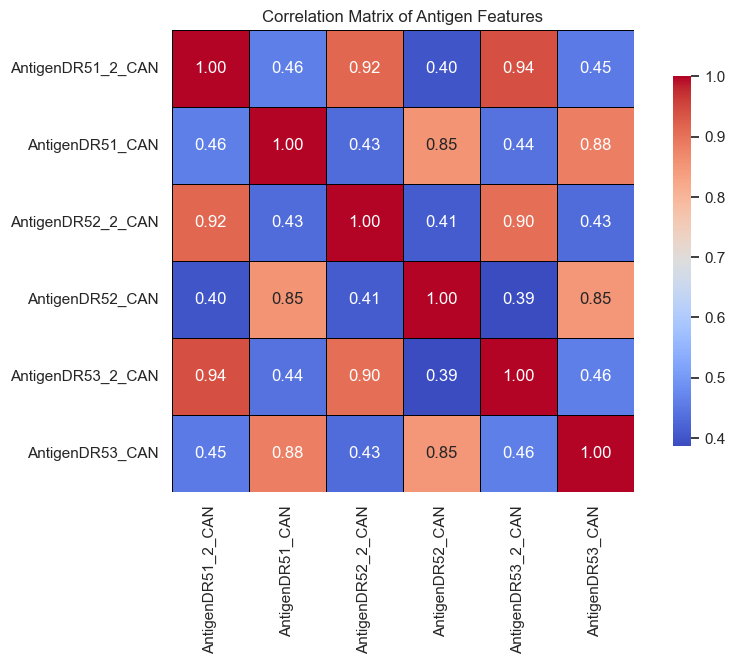

In [61]:
corrMatrix = df[['AntigenDR51_2_CAN', 'AntigenDR51_CAN', 'AntigenDR52_2_CAN', 'AntigenDR52_CAN', 'AntigenDR53_2_CAN', 'AntigenDR53_CAN']].corr()

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corrMatrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, 
            cbar_kws={"shrink": .8}, linewidths=0.5, linecolor='black')

plt.title('Correlation Matrix of Antigen Features')
plt.show()

In [62]:
# new feature
df['Total_AntigensDR_CAN'] = df[['AntigenDR51_2_CAN', 'AntigenDR51_CAN', 'AntigenDR52_2_CAN', 'AntigenDR52_CAN', 'AntigenDR53_2_CAN', 'AntigenDR53_CAN']].sum(axis=1)

# add to list
removeCol.extend(['AntigenDR51_2_CAN', 'AntigenDR51_CAN', 'AntigenDR52_2_CAN', 'AntigenDR52_CAN', 'AntigenDR53_2_CAN', 'AntigenDR53_CAN'])

# add to ordinal DataFrame
df_ordinal.loc[len(df_ordinal)] = 'Total_AntigensDR_CAN'

# need encoding
ordinalEconding.extend(['Total_AntigensDR_CAN'])

##### AntigenHLAcompatibility

In [63]:
df[['AntigenHLAcompatibility_A1', 'AntigenHLAcompatibility_A2', 'AntigenHLAcompatibility_B1', 'AntigenHLAcompatibility_B2', 'AntigenHLAcompatibility_DR1', \
    'AntigenHLAcompatibility_DR2', 'AntigenHistocompatibility_B1_DON', 'AntigenHistocompatibility_B2_DON', 'AntigenHistocompatibility_DA1_DON', \
    'AntigenHistocompatibility_DA2_DON', 'AntigenHistocompatibility_DR1_DON', 'AntigenHistocompatibility_DR2_DON']].describe().T

,count,mean,std,min,25%,50%,75%,max
AntigenHLAcompatibility_A1,14856.0,5.330304,7.097808,0.0,2.0,2.0,6.0,46.0
AntigenHLAcompatibility_A2,14856.0,12.478931,8.581451,0.0,6.0,11.0,19.0,46.0
AntigenHLAcompatibility_B1,14856.0,14.682283,16.774161,0.0,2.0,9.0,23.0,91.0
AntigenHLAcompatibility_B2,14856.0,25.364701,16.597940,0.0,16.0,23.0,32.0,92.0
AntigenHLAcompatibility_DR1,14856.0,9.243269,7.460543,0.0,4.0,7.0,13.0,52.0
AntigenHLAcompatibility_DR2,14856.0,11.586632,8.166553,0.0,8.0,11.0,12.0,54.0
AntigenHistocompatibility_B1_DON,14856.0,11.688611,12.934591,0.0,1.0,7.0,19.0,78.0
AntigenHistocompatibility_B2_DON,14856.0,22.416667,12.674271,0.0,15.0,22.0,31.0,82.0
AntigenHistocompatibility_DA1_DON,14856.0,2.808158,4.236935,0.0,1.0,1.0,4.0,37.0
AntigenHistocompatibility_DA2_DON,14856.0,9.360797,6.712002,0.0,4.0,9.0,13.0,41.0


In [64]:
# new feature
df['Total_AntigenHLA'] = df[['AntigenHLAcompatibility_A1', 'AntigenHLAcompatibility_A2', 'AntigenHLAcompatibility_B1', 'AntigenHLAcompatibility_B2', 'AntigenHLAcompatibility_DR1', \
    'AntigenHLAcompatibility_DR2']].sum(axis=1)

df['Total_AntigenHist_DON'] = df[['AntigenHistocompatibility_B1_DON', 'AntigenHistocompatibility_B2_DON', 'AntigenHistocompatibility_DA1_DON', \
    'AntigenHistocompatibility_DA2_DON', 'AntigenHistocompatibility_DR1_DON', 'AntigenHistocompatibility_DR2_DON']].sum(axis=1)

# add to list
removeCol.extend(['AntigenHLAcompatibility_A1', 'AntigenHLAcompatibility_A2', 'AntigenHLAcompatibility_B1', 'AntigenHLAcompatibility_B2', 'AntigenHLAcompatibility_DR1', \
    'AntigenHLAcompatibility_DR2', 'AntigenHistocompatibility_B1_DON', 'AntigenHistocompatibility_B2_DON', 'AntigenHistocompatibility_DA1_DON', \
    'AntigenHistocompatibility_DA2_DON', 'AntigenHistocompatibility_DR1_DON', 'AntigenHistocompatibility_DR2_DON'])

# add to ordinal DataFrame
df_ordinal.loc[len(df_ordinal)] = 'Total_AntigenHLA'
df_ordinal.loc[len(df_ordinal)] = 'Total_AntigenHist_DON'

# need encoding
ordinalEconding.extend(['Total_AntigenHLA', 'Total_AntigenHist_DON'])

##### FunctionalStatus_CAN
-  Duplicate feature: `PreTransplantMedicalCondition_CAN`

In [65]:
# add to list
removeCol.extend(['FunctionalStatus_CAN'])

#### Ordinal Encoding New Features

In [66]:
# import libraries
from sklearn.preprocessing import OrdinalEncoder

# iterate each Antigen features
for col in ordinalEconding:
    # get order
    ordering = list(sorted(df[col].unique()))
    # initialize encoder
    encoder = OrdinalEncoder(categories=[ordering])
    # transform
    df[col] = encoder.fit_transform(df[[col]])

#### Boolean

In [67]:
print(sorted(df_bool.boolean.to_list()))

['BloodInfectionSource_DON', 'Gender_CAN', 'Gender_DON', 'IntropesIV_CAN', 'KidneyAllocation_DON', 'LifeSupportInhaled_CAN', 'LifeSupport_ECMO_CAN', 'LifeSupport_IABP_CAN', 'LifeSupport_OTHER_CAN', 'LifeSupport_PGE_CAN', 'PreviousTransplantAnyOrgan_CAN', 'PreviousTransplantSameOrgan_CAN', 'PulmonaryInfection_DON', 'ResultHIV_NAT_DON', 'TransplantStatus_CAN', 'UrineInfection_DON', 'Ventilator_CAN']


In [68]:
# new feature
df['Gender_Difference'] = df.Gender_CAN == df.Gender_DON

# add to list
removeCol.extend(['Gender_CAN', 'Gender_DON'])

# add to boolean DataFrame
df_bool.loc[len(df_bool)] = 'Gender_Difference'

#### Test of Independence for Categorical Variables
- Null Hypothesis (H0): The two variables are not related.
- Alternative Hypothesis (H1): The two variables are related.
- A low p-value (typically < 0.05) indicates a significant relationship between the variables.
- This is the Chi-Square test statistic. It measures the discrepancy between the observed and expected frequencies under the assumption that the variables are independent.
    - A larger `chi2` value indicates a greater difference between observed and expected counts, suggesting that the variables are more likely to be associated.
    - A small p_value (typically < 0.05) suggests that you can reject the null hypothesis and conclude that there is a significant association between the two variables.

#### Cramer's V values can be interpreted as:
- Cramer's V is a measure of association between two nominal (categorical) variables, based on the Chi-Square statistic and varies from `0` (corresponding to no association between the variables) to `1` (complete association) and can reach 1 only when each variable is completely determined by the other.
    - 0.00 to 0.10: Negligible association
    - 0.10 to 0.30: Weak association
    - 0.30 to 0.50: Moderate association
    - 0.50 to 0.70: Strong association
    - 0.70 to 1.00: Very strong association

In [69]:
df_label

,label
0,FollowUpFunctionalStatus_CAN
1,AirwayDehiscencePostTransplant_CAN
2,AcuteRejectionEpisode_CAN
3,StrokePostTransplant_CAN
4,PacemakerPostTransplant_CAN
5,GraftFailed_CAN
6,LastFollowupNumber_CAN
7,TransplantStatus_CAN
8,TransplantSurvivalDay_CAN
9,RecipientStatus_CAN


#### Remove Features

In [70]:
# remove features and house keeping
df, df_bool, df_ordinal, df_nominal, df_numeric, df_label = removeHouseKeeping(df, removeCol, df_bool, df_ordinal, df_nominal, df_numeric, df_label)

Remove row(s) from df_label DataFrame.
Remove row(s) from df_boolean DataFrame.
Remove row(s) from df_ordinal DataFrame.
Remove row(s) from df_nominal DataFrame.
Remove row(s) from df_numeric DataFrame.

Removed Features:['AgeCalc_DON', 'Age_CAN', 'BMI_CAN', 'BMI_DON', 'Creatinine_CAN', 'Creatinine_DON', 'HeightCm_CAN', 'HeightCm_DON', 'Hemodynamics_CO_CAN', 'Hemodynamics_PA_DIA_CAN', 'Hemodynamics_PA_MN_CAN', 'Hemodynamics_PCW_CAN', 'Hemodynamics_SYS_CAN', 'Level_SGOT_ALT_DON', 'Level_SGOT_AST_DON', 'TotalBilirubin_CAN', 'TotalBilirubin_DON', 'WeightKg_CAN', 'WeightKg_DON', 'BloodGroup_CAN', 'BloodGroup_DON', 'BronchoscopyLeft_DON', 'BronchoscopyRight_DON', 'ExtracanialCancer_DON', 'IntracanialCancer_DON', 'HistoryCancer_DON', 'SkinCancer_DON', 'Cancer_DON', 'CauseOfDeath_DON', 'Diabetes_DON', 'DialysisPrior_CAN', 'EpsteinBarr_IGG_DON', 'EpsteinBarr_IGM_DON', 'IntropesVasodilators_CO_CAN', 'IntropesVasodilators_DIA_CAN', 'IntropesVasodilators_MN_CAN', 'IntropesVasodilators_PCW_CAN', '

In [71]:
# initialize list
boolCol, nominalCol, ordinalCol, numericCol =  datatypeDF(df, df_bool, df_nominal, df_ordinal, df_numeric)   

Total Data feature count:  124

Boolean feature count: 11
Nominal feature count: 79
Ordinal feature count: 15
Numeric feature count: 19

Total feature count:  124


In [72]:
print(sorted(boolCol))

['BloodInfectionSource_DON', 'Gender_Difference', 'IntropesIV_CAN', 'KidneyAllocation_DON', 'PreviousTransplantAnyOrgan_CAN', 'PreviousTransplantSameOrgan_CAN', 'PulmonaryInfection_DON', 'ResultHIV_NAT_DON', 'TransplantStatus_CAN', 'UrineInfection_DON', 'Ventilator_CAN']


In [73]:
print(sorted(nominalCol))

['AcuteRejectionEpisode_CAN', 'AirwayDehiscencePostTransplant_CAN', 'AntibodyResultHBSAB_DON', 'Antibody_HEP_C_DON', 'Antihypertensive_DON', 'ArginnieManagement_DON', 'AtTransplantSurfaceHBVAntibodyTotal_CAN', 'Biopsy_DON', 'Bronchoscopy_DON_Combined', 'CMVStatusAtTransplant_CAN', 'Cancer_DON_Combined', 'CardiacArrest_DON', 'CerebrovascularDisease_CAN', 'ChestXray_DON', 'ChronicSteroidsUse_CAN', 'CigaretteHistory_DON', 'CigaretteUse_CAN', 'ClinicalInfection_DON', 'CocaineUse_DON', 'CoronaryAngiogram_DON', 'CrossMatch', 'DeathMechanism_DON', 'DeceasedRetyped_DON', 'DefibrillatorImplant_CAN', 'Diabetes_CAN', 'DiagnosisType_CAN', 'DialysisAfterList_CAN', 'Diuretics_DON', 'EpsteinBarrStatusTransplant_CAN', 'EpsteinBarr_DON_Combined', 'FollowUpFunctionalStatus_CAN', 'GraftFailed_CAN', 'GraftStatus_CAN', 'HeartProcedureType_CAN', 'HeavyAlcoholUse_DON', 'HeparinManagement_DON', 'Hepatitis_B_CoreAntibody_CAN', 'Hepatitis_B_CoreAntibody_DON', 'Hypertension_DON', 'InfectionTherapyIV_CAN', 'Inotr

In [74]:
print(sorted(ordinalCol))

['AntigenBW4_BW6_CAN_Addition', 'AntigenC1_C2_CAN_Addition', 'AntigenDQ1_DQ2_CAN_Addition', 'BloodGroupMatchLevel', 'DiabetesHistory_DON', 'EducationLevel_CAN', 'MismatchLevel_B_LOCUS', 'MismatchLevel_DR_LOCUS', 'MismatchLevel_HLA', 'MismatchLevel_LOCUS', 'PreTransplantMedicalCondition_CAN', 'PreviousTransplantNumber_CAN', 'Total_AntigenHLA', 'Total_AntigenHist_DON', 'Total_AntigensDR_CAN']


In [75]:
print(sorted(numericCol))

['Age_Difference', 'BMI_Difference', 'BloodPH_DON', 'BloodUreaNitrogenLevel_DON', 'Creatinine_Difference', 'DistanceFrom_HospitaltoTXCenter', 'HeightCm_Difference', 'Hematocrit_DON', 'Hemodynamics_CAN_Addtion', 'IschemicTimeHours_DON', 'LV_EjectionFractionPercent_DON', 'LengthOfStay_CAN', 'Level_SGOT_DON_Difference', 'PCO2_DON', 'PF_Ratio_DON', 'TotalBilirubin_Difference', 'TotalDayWaitList_CAN', 'TransplantSurvivalDay_CAN', 'WeightKg_Difference']


### Save to DISK

In [76]:
# full dataframe
df.to_pickle("../Data/CleanFullLabelsML.pkl")
df.to_csv("../Data/CleanFullLabelsML.csv", header=False)

# data dict
df_dict.to_pickle("../Data/FinalcolumnDefinitionML.pkl")

# boolean
df_bool.to_pickle("../Data/colBooleanML.pkl")

# nominal
df_nominal.to_pickle("../Data/colNominalML.pkl")

# ordinal
df_ordinal.to_pickle("../Data/colOrdinalML.pkl")

# numeric
df_numeric.to_pickle("../Data/colNumericML.pkl")

# label
df_label.to_pickle("../Data/colLabelML.pkl")